# Most Influential Attributes of Top Teams 
## Exploring the Data of the EU Soccer League

The goal of this analysis will be to see if there are common attributes amoung the top performing leagues in the European Soccer League and most the most defining attritbutes are. Data is from a Kaggle post, [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) by Hugomathien.

The process of discovery will be the following:
1. Create SQL queries to import data into Pandas
2. Find out which teams the players belong too (most recent year)
3. Join the player attributes to those teams (most recent performance scores)
4. Create team attributes based on the mean of players' attributes
5. Discover the top teams (most recent year)
6. Compare the mean attributes of all teams compared to the mean attributes of top teams
7. Make a judgement if there are common attributes that matter most to success

## Setting Up Environment

First, I want to make sure I have my enviroments set up. I will be working on two computer, a mac pro (at work) and my Chromebook <3. To code on my Chromebook, I have set up a cloud instance with [Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html), created a [GitHub Repo](https://github.com/GarrettMarkScott/European_Soccer_Exploring) for the project so I can work on it from both machines.

I used the below code to check to make sure my environment was working and that our modules and data are correctly importing without error.

In [49]:
#These are the general items for simple loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import itertools
import pprint

pp = pprint.PrettyPrinter(indent=4)

conn = sqlite3.connect('soccer_data.sqlite')
tables = pd.read_sql('SELECT * FROM sqlite_master WHERE type="table";', conn)
countries = pd.read_sql('SELECT * FROM Country;', conn)
players = pd.read_sql('SELECT player_api_id, player_name FROM Player;', conn)
player_att = pd.read_sql('SELECT * FROM Player_Attributes;',conn)
league_teams = pd.read_sql('SELECT team_long_name FROM Team', conn)
#player_att.columns.tolist() #I use this line for previewing original data

## Connecting Players to Teams

This was my first time working with a SQLite database and it was a pleasure. While we could of wrote the SQL queries directly in Jupyter, I chose to load the SQLite datebase into [DB Browser for SQLite] for quick SQL Queries and easier comprehension.

I spent quite a bit of time trying to figure out how to merge the players to teams. As seen in the screenshot below there was not a common key between player and team. My assumption is that this is due to players switching various teams over their career.

![Table Screenshot](https://i.imgur.com/KCpqgS5.jpg)

My solution to matching players to teams is the query below. It uses the Match table data to see which players were associated with each match. Now having the player ids we can later connect them to their names. It is assumed that these 11 players are the starting roster for each team. 

This turned out to be a pretty big challege because I did not relize DB Browser for SQLite seemingly does not have a formal Date type but rather stores date types as a *Timestring* format. This one really threw my for a loop and it turned out that a simple `BETWEEN` function still worked fine. If anyone has more information regarding *Timestring* format I have made a [Stack Overflow Post](https://stackoverflow.com/questions/56202599/converting-timestrings-to-datetime-db-browser) requesting more information.

In [50]:
#Matches from most recent season and the starting players (in ID format)
#Note the season date are hardcoded
#Is there an easy solution to use variables for date range?
matches = pd.read_sql_query('''SELECT t.team_long_name, m.home_player_1, m.home_player_2, 
                                      m.home_player_3,m.home_player_4, m.home_player_5,
                                      m.home_player_6, m.home_player_7, m.home_player_8,
                                      m.home_player_9, m.home_player_10, m.home_player_11,
                                      m.date, m.home_team_goal, m.away_team_goal 
                                 FROM Team t 
                                 JOIN Match m ON t.team_api_id = m.home_team_api_id 
                                WHERE DATE(m.date) BETWEEN "2015-05-01" and "2016-05-25"
                                ORDER BY t.team_long_name;''', conn, )
#matches

## Connecting Player ID to Player Name
To keep our code modular as possible the function below can be used to return a player's name based on ID input.

The first result **player_api_id** is the test and you will see that it returns **Aaron Appindangoye** correctly.

In [51]:
players.iloc[[0]]

,player_api_id,player_name
0,505942,Aaron Appindangoye


In [52]:
def player_id_to_name(id): 
    return(players[players['player_api_id'] == id].iloc[0,1])

player_id_to_name(505942)

'Aaron Appindangoye'

## Creating Compound Dictionary of Teams, Players, & Attributes

Next, I want to create a compound dictionary to store teams, players, and attributes. Will will be using the hardcoded date range from our SQL query. It is assumed that the players stay with one year/season. <br>
**This is the goal:**
```
teams = {"team 1": {"Player 1": {"Dribbling": 4,
                                 "Attack": 5,
                                 "Speed": 9},
                    "Player 2": {"Dribbling": 6,
                                 "Attack": 10,
                                 "Speed": 3},
                    "Player 3": {"Dribbling": 2,
                                 "Attack": 5,
                                 "Speed": 8},
                    },
         "team 2": {"Player 1": {"Dribbling": 9,
                                 "Attack": 6,
                                 "Speed": 2},
                    "Player 2": {"Dribbling": 10,
                                 "Attack": 2,
                                 "Speed": 8},
                    "Player 3": {"Dribbling": 5,
                                 "Attack": 5,
                                 "Speed": 5},
                    }
            }
```

### Step 1: Create a list of teams

In [53]:
#Create a list of the teams to iterate
team_names = league_teams.values.tolist()
merged_team_names = list(itertools.chain(*team_names)) #Flatten list of lists
team_names = merged_team_names
print('There are '+str(len(team_names))+' teams in the team_names list')
#pprint.pprint(team_names)

There are 299 teams in the team_names list


### Step 2: Create a list of starting players for each team
We create a funtion that returns a flattened list of players for a given team. It retains their id numbers for later manipulation. 

In [54]:
def get_team_players(x):
    #Gather all the players that have started in the match data. 
    all_team_players = matches[matches['team_long_name'] == x].iloc[:,2:12].values.astype(int).tolist()
    merged_team_players = list(itertools.chain(*all_team_players)) #flattens list of lists
    

    #this gathers all the players api numbers, contrains to unique numbers, and stores them in variable
    all_team_players = [] #resets variable for append function below
    for i in merged_team_players:  
        name = i
        if name not in all_team_players:
            all_team_players.append(name)
        else:
            pass
    return(all_team_players)

print(get_team_players('1. FC Köln')) #This is just an example of the funtion working.

[36395, 36934, 264221, 307210, 36086, 167589, 127945, 459493, 166449, 196366, 22824, 450976, 231753, 303800, 177941, 71605, 260470, 238438, 212377, 28435, 259439]


### Step 3: Connect Player Attributes to Teams in Compound Dictionary

A roadblock was that the team_names variable was returning single item lists that needed to be converted into strings for itterating.

In [55]:
#print('The type of team_names[0] is: '+ str(type(str(team_names)))) #It was a LIST!!!! Now string

teams = {}
for i in range(len(team_names)):   #Itterate through all teams
    try:
        player_apis = get_team_players(str(team_names[i])) #Converting from list to string
        player_names = {}
        for api in player_apis:
            player_name = player_id_to_name(api)
            player_names[player_name] = player_att[player_att['player_api_id'] == api].iloc[1,:].transform(dict)
        teams[team_names[i]] = player_names
    except:
        #print('Team had no players registered')
        pass

#pp.pprint(teams) 

### Finished: Compound Dictionary Now Completed!
**Use the cell below to test different dictionary lookups.**

In [56]:
teams['Hull City']["Dame N'Doye"]

{'id': 33945,
 'player_fifa_api_id': 179875,
 'player_api_id': 101969,
 'date': '2016-01-21 00:00:00',
 'overall_rating': 77.0,
 'potential': 77.0,
 'preferred_foot': 'right',
 'attacking_work_rate': 'high',
 'defensive_work_rate': 'medium',
 'crossing': 56.0,
 'finishing': 75.0,
 'heading_accuracy': 77.0,
 'short_passing': 63.0,
 'volleys': 71.0,
 'dribbling': 74.0,
 'curve': 69.0,
 'free_kick_accuracy': 70.0,
 'long_passing': 38.0,
 'ball_control': 74.0,
 'acceleration': 78.0,
 'sprint_speed': 78.0,
 'agility': 74.0,
 'reactions': 75.0,
 'balance': 56.0,
 'shot_power': 85.0,
 'jumping': 70.0,
 'stamina': 79.0,
 'strength': 84.0,
 'long_shots': 74.0,
 'aggression': 72.0,
 'interceptions': 40.0,
 'positioning': 79.0,
 'vision': 64.0,
 'penalties': 60.0,
 'marking': 35.0,
 'standing_tackle': 38.0,
 'sliding_tackle': 19.0,
 'gk_diving': 14.0,
 'gk_handling': 13.0,
 'gk_kicking': 9.0,
 'gk_positioning': 8.0,
 'gk_reflexes': 16.0}

# Picking Top Teams
We now have a nice dictionary of the teams, their registered players, and their attributes. Now let's write a command to discover the team with the most wins. Let's use some visualization to help us determine if we want data from the top 3, top 5, etc. out of the 299 teams.

This should be based on winning percent vs. total sum.

### Step 1: Create Points per Match
The code below appends 2 additional columns. The first is `'final_status'` to show who won. `'points_awarded'` then delivers a point system for 'win' and 'tie'. This number will be used to determine the top teams.

In [57]:
matches['final_status'] = "NaN" #Creates placeholder
matches['points_awarded'] = 0
matches.loc[matches['home_team_goal'] > matches['away_team_goal'], ['final_status','points_awarded']] = ['win',2]
matches.loc[matches['home_team_goal'] == matches['away_team_goal'], ['final_status','points_awarded']] = ['tie',1]
matches.loc[matches['home_team_goal'] < matches['away_team_goal'], 'final_status'] = 'lose'
#matches.head(25)

Now that we have the points for each team. The next step is to figure out how many games they each played.

### Step 2: Create Points per Team
In the last code snip we assigned a point value for each match, this sums those points for each team.

In [58]:
team_points = matches.groupby(['team_long_name']).sum()[['points_awarded']]
#team_points

### Step 3: Counting Games Played per Team

In [59]:
team_games_played = matches.groupby(['team_long_name']).count()[['date']]
team_games_played.rename(columns={'date':'games_played'}, inplace=True) #proper rename
#team_games_played

### Step 4: Create Performance Score per Team

This is a custom agregation that is powered by the point system we assigned for winning matches. 2 points/win and 1 point/tie. Some teams played more games than others in the season so using a total sum would not be accurate. This being said we got the percentage (that could be up to 200% if they won every match). To simplify the metric I multiplied the percentage by 100 to create the *performance_score* column.

There were a number of teams that only a few games matches recorded. I decided for a team to be considered in the running for top team, 10 games or more have to had been played. I permanently removed teams that did not meet that qualification. Otherwise our sorted list would be difficult to work with as some teams that only played 1 game and won would have a performance score of 200.

In [60]:
team_totals = team_games_played.join(team_points)
team_totals['performance_score'] = ((team_totals['points_awarded'] / team_totals['games_played'])*100).astype(int)
team_totals.sort_values('performance_score', ascending=False, inplace=True)
team_totals = team_totals[team_totals['games_played'] >= 10] 
team_totals

,games_played,points_awarded,performance_score
team_long_name,,,
Club Brugge KV,15,28,186
Napoli,21,39,185
Borussia Dortmund,19,35,184
SL Benfica,19,34,178
Paris Saint-Germain,21,37,176
Juventus,21,37,176
Piast Gliwice,15,26,173
FC Bayern Munich,19,33,173
Sporting CP,19,33,173


As a rather barbaric quality test I googled a couple of the top teams to see if they are still top placers (since data is from 2016). An example is that Napoli is currently 2nd in the Italian league (05/25/19). I will consider our `'performance_score'` number as an accurate indicator and continue moving forward.

Two key variables that have been created are:
* Teams (compound dictionary with players & attributes)
* Team_Totals (dataframe indicating top teams)

## Create Function to Get Team Attribute Averages
The next section of this will be to make a function that returns the team's average attributes. We will use this function to gather the average attributes of all teams for camparison against attributes of the top teams.

In [71]:
def average_team_attributes(team):
    team_stats = pd.DataFrame.from_dict(teams[team])
    team_stats = team_stats.T
    return(team_stats.mean(axis = 0))

#average_team_attributes('Aberdeen')   

## Create Final DataFrames for Team Attributes
We will build a dataframe that contains the attributes of all teams as well as a dataframe for just top teams. For each dataframe we will get the mean statistics then merge them together for our comparitive analysis.

### Average Attributes of All Teams

In [72]:
def build_final_dataframe(list_of_teams):
    frame = {}
    team_exclusions = []
    for i in list_of_teams:
        try:
            frame[i] = average_team_attributes(i)
        except:
            team_exclusions.append(i)
            pass
    all_teams = pd.DataFrame(frame)
    return all_teams.drop(['player_api_id','player_fifa_api_id','id'])

    
averages_all_teams = build_final_dataframe(team_totals.index.tolist()) 
#averages_all_teams

### Average Attributes of Top Teams

In [74]:
number_of_top_teams = 5
averages_top_teams = build_final_dataframe(team_totals.index[0:6])
#averages_top_teams

## Analyze & Visualize Our Findings
Two key variables that have been created are:
* averages_all_teams (DataFrame)
* averages_top_teams (DataFrame)

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
joined_averages = pd.concat([averages_all_teams.mean(axis = 1), averages_top_teams.mean(axis = 1)], axis=1)
joined_averages.columns = ['All Teams','Top Teams']
joined_averages['% Diff'] = ((1-(joined_averages['All Teams']/joined_averages['Top Teams']))*100).round(0)
joined_averages.sort_values('% Diff', ascending=False, inplace=True)

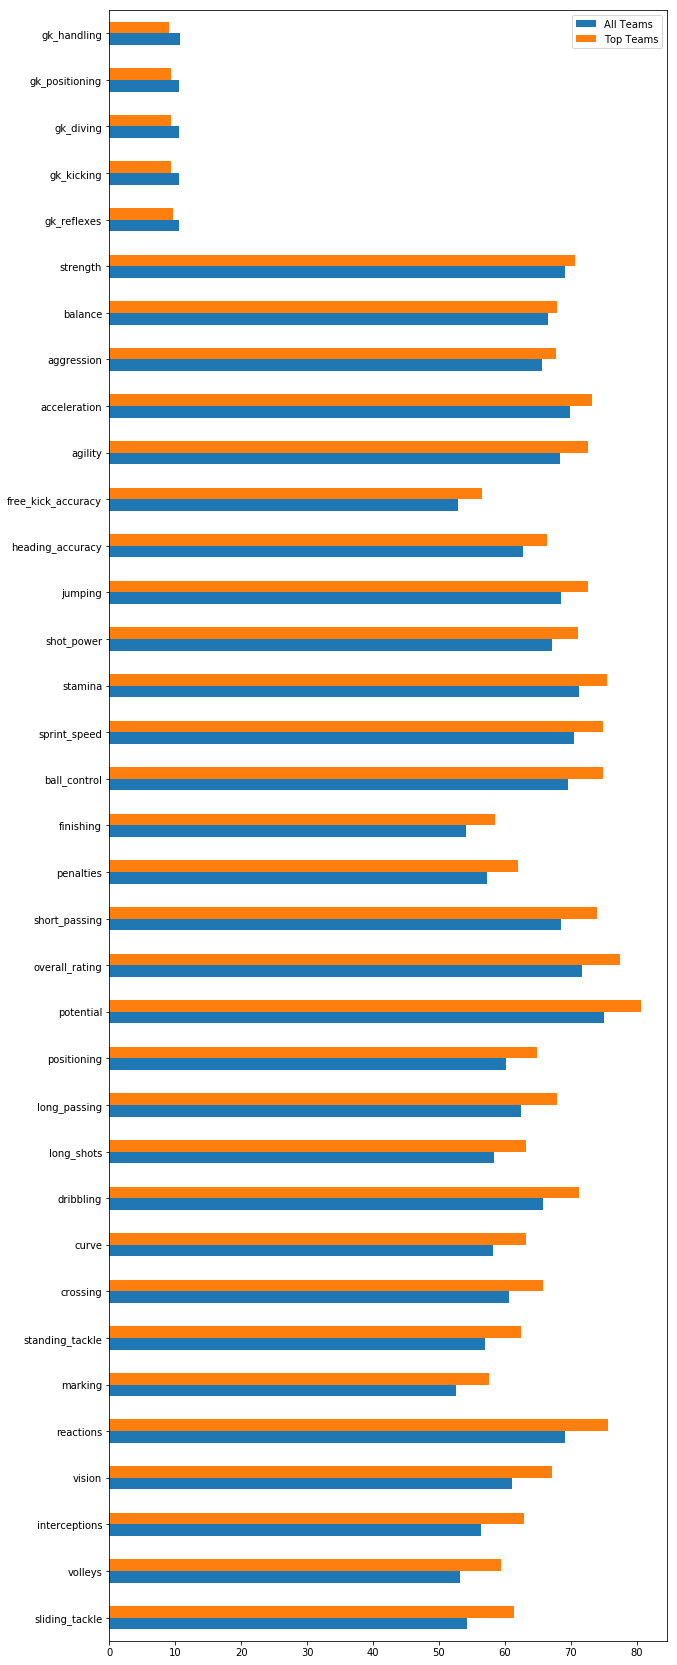

In [78]:
joined_averages[['All Teams','Top Teams']].plot(kind='barh', figsize=(10,30));

In [79]:
joined_averages

,All Teams,Top Teams,% Diff
sliding_tackle,54.291691,61.423964,12.0
volleys,53.206841,59.472902,11.0
interceptions,56.398186,62.852940,10.0
vision,61.136356,67.147993,9.0
reactions,69.054530,75.704668,9.0
marking,52.514383,57.631611,9.0
standing_tackle,56.939278,62.420254,9.0
crossing,60.613370,65.845461,8.0
curve,58.208347,63.180607,8.0
dribbling,65.820371,71.192884,8.0


# Final Conclusion
## Possession is Everything!
Our original quest was to find the top attributes of winning teams in the European Soccer Leauge. To do this we cleaned the data and then compared the averages attributes of all teams with the attributes of the top 5 teams in the league.

Before diving into the data, I had thoughts that maybe the speed attributes would be one of the biggest contributing factors. I was pretty far from the truth. It became clear that **top teams had players that excelled at winning ball possession**. Those top attributes being sliding tackles, volleys, and interceptions.

This information would be extremely relevant for talent scouts, recruiters, or investors looking to buy/bid on a team.

An interesting fact that was that, according to Fifa player stats, the goalies on winning teams were less than average in every category.